In [25]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2


In [26]:
BASE_DIR = "/home/min/main/Ph2"
EXCEL_NAME = "PH2_dataset.xlsx" 
excel_path = os.path.join(BASE_DIR, EXCEL_NAME)

IMAGES_DIR = os.path.join(BASE_DIR, "PH2 Dataset images")

In [27]:
imd_folders = sorted(glob.glob(os.path.join(IMAGES_DIR, "IMD*")))

print(f"총 {len(imd_folders)}개 사례(IMD 폴더) 발견.")

counts_derm = 0
counts_lesion = 0
counts_roi = 0

all_image_info = []  

for folder_path in imd_folders:
    case_id = os.path.basename(folder_path)  # "IMD002"
    
    derm_folder   = os.path.join(folder_path, f"{case_id}_Dermoscopic_Image")
    lesion_folder = os.path.join(folder_path, f"{case_id}_lesion")
    roi_folder    = os.path.join(folder_path, f"{case_id}_roi")

    derm_files   = glob.glob(os.path.join(derm_folder, "*.bmp"))
    lesion_files = glob.glob(os.path.join(lesion_folder, "*.bmp"))
    roi_files    = glob.glob(os.path.join(roi_folder, "*.bmp"))

    counts_derm   += len(derm_files)
    counts_lesion += len(lesion_files)
    counts_roi    += len(roi_files)

    all_image_info.append({
        "case_id": case_id,
        "derm_files": derm_files,      
        "lesion_files": lesion_files,  
        "roi_files": roi_files        
    })

print(f"[Dermoscopic] 총 {counts_derm}개 파일")
print(f"[Lesion]      총 {counts_lesion}개 파일")
print(f"[ROI]         총 {counts_roi}개 파일")

총 200개 사례(IMD 폴더) 발견.
[Dermoscopic] 총 200개 파일
[Lesion]      총 200개 파일
[ROI]         총 50개 파일


  case_id  n_derm  n_lesion  n_roi
0  IMD002       1         1      2
1  IMD003       1         1      1
2  IMD004       1         1      2
3  IMD006       1         1      0
4  IMD008       1         1      0


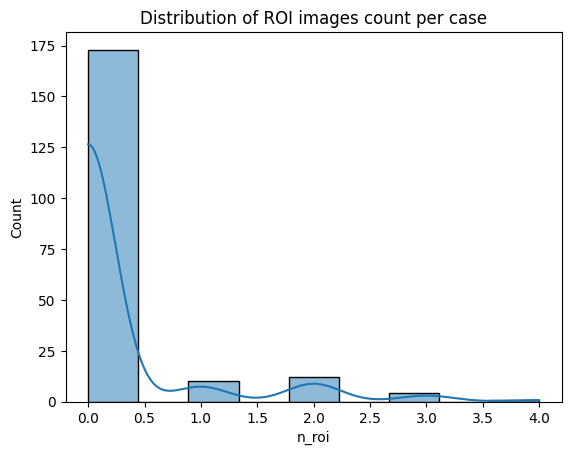

In [28]:
case_stats = []
for info in all_image_info:
    case_stats.append({
        "case_id": info["case_id"],
        "n_derm": len(info["derm_files"]),
        "n_lesion": len(info["lesion_files"]),
        "n_roi": len(info["roi_files"])
    })
df_case_stats = pd.DataFrame(case_stats)
print(df_case_stats.head())

sns.histplot(data=df_case_stats, x="n_roi", kde=True)
plt.title("Distribution of ROI images count per case")
plt.show()

# Dataset 설명 

- `IMD###_Dermoscopic_Image`: 실제 피부 병변(모반) 부위를 컬러로 촬영한 원본에 가까운 이미지
- `IMD###_lesion`: 병변(lesion) 부분을 마스킹하거나, 병변 영역만 명확히 강조한 이미지
- `IMD###_roi`: ROI(Region of Interest)에 대한 레이블 이미지들이 들어있는데, label3, label4 등으로 여러 개의 세부 구역을 표시한 경우가 있음

## Lesion 이미지 , ROI(마스킹) 이미지 

### Lseion 

- 주된 특징: 병변(lesion) 부분을 흰색(또는 다른 컬러)으로 표시하고, 배경은 검정색/검은색에 가깝게 표현하는 형태가 많습니다.

- 예: IMD002_lesion.bmp 내부를 보면, 병변을 제외한 영역은 0 (검은색), 병변 부분은 255(흰색) 등으로 표현된 바이너리(흑백) 마스크일 수 있습니다. 혹은 병변 영역만 컬러로 나오고, 배경은 검정색으로 마스킹된 형태일 수도 있습니다.

- 주 사용처:
    - 세그멘테이션(병변 경계 인식) 모델 학습 시 **Ground Truth(정답 라벨)**로 사용
    - 병변 면적이나 모양(경계, 직경 등) 추출 시 참조

### ROI 

- 주된 특징: "ROI(Region of Interest)"라고 불리는, 하나 이상의 부분 영역을 추가로 강조하거나, 병변 내 특정 레이블(ex: label3, label4)을 구분하여 저장해놓은 이미지들이 있습니다.

- 예시: IMD002_R1_Label4.bmp, IMD002_R2_Label3.bmp
    - 보통 이처럼 라벨 번호가 붙은 bmp 파일이 여러 장 있을 수 있습니다.
    - 어떤 이미지는 병변의 경계만, 다른 이미지는 병변 내부의 특이 부위만 표시하는 등, **여러 구역(ROI)**을 따로 저장한 경우입니다.

- 주 사용처:
    - 병변 내부 세부 영역 분석(색소 침착, 특정 구조 등)
    - 다중 레이블 세그멘테이션
    - 혹은 의학적 연구 목적(특정 ROI만 뽑아 분석)




## 데이터 확인

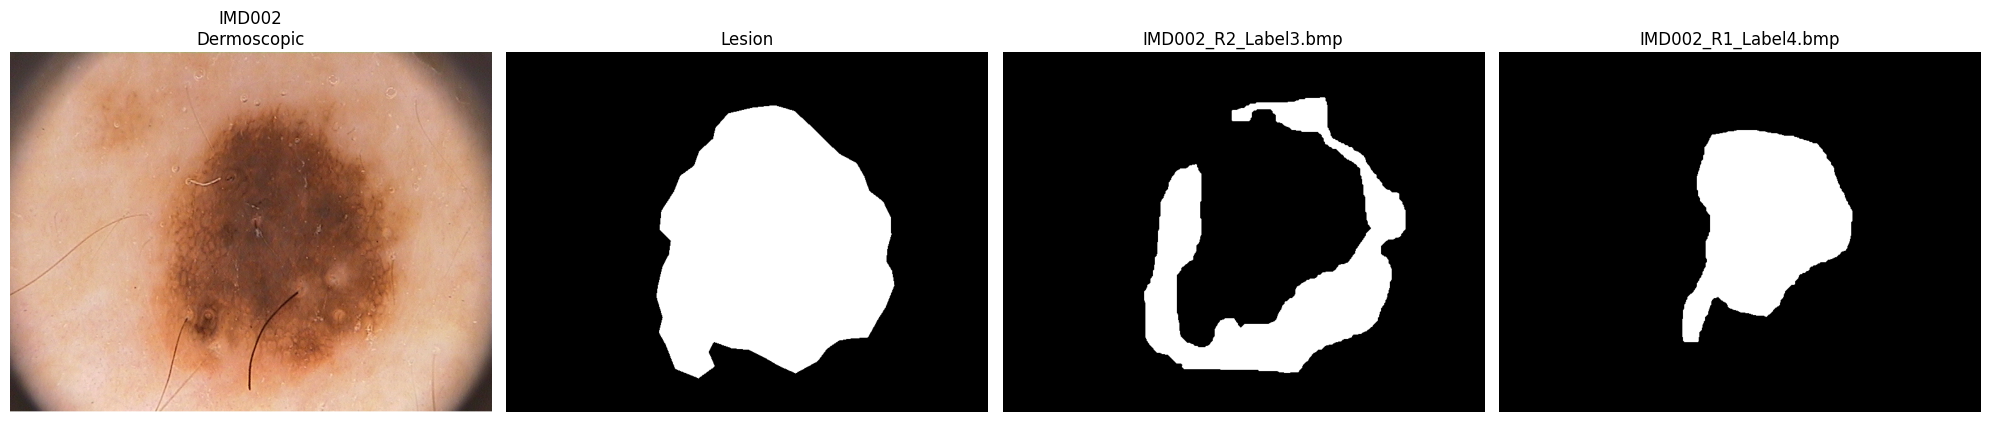

In [29]:
def show_images_comparison(derm_path, lesion_path=None, roi_paths=None, case_id="Unknown"):

    n_roi = len(roi_paths) if roi_paths else 0
    n_images = 1 + (1 if lesion_path else 0) + n_roi

    fig, axes = plt.subplots(1, n_images, figsize=(5 * n_images, 5))
    if n_images == 1:
        axes = [axes] 

    idx = 0
    # 1) dermoscopic
    derm_img = Image.open(derm_path).convert('RGB')
    axes[idx].imshow(derm_img)
    axes[idx].set_title(f"{case_id}\nDermoscopic")
    axes[idx].axis('off')
    idx += 1

    # 2) lesion
    if lesion_path:
        lesion_img = Image.open(lesion_path).convert('RGB')
        axes[idx].imshow(lesion_img)
        axes[idx].set_title("Lesion")
        axes[idx].axis('off')
        idx += 1

    # 3) ROI
    if roi_paths:
        for rpath in roi_paths:
            roi_img = Image.open(rpath).convert('RGB')
            axes[idx].imshow(roi_img)
            axes[idx].set_title(os.path.basename(rpath))
            axes[idx].axis('off')
            idx += 1

    plt.tight_layout()
    plt.show()

# 예: IMD002 케이스 이미지를 비교 시각화
sample_case_id = "IMD002"  # 바꿔서 테스트 가능
sample_info = None
for info in all_image_info:
    if info["case_id"] == sample_case_id:
        sample_info = info
        break

if sample_info:
    if len(sample_info["derm_files"]) > 0:
        derm_path = sample_info["derm_files"][0]
        lesion_path = sample_info["lesion_files"][0] if len(sample_info["lesion_files"])>0 else None
        roi_paths = sample_info["roi_files"]
        show_images_comparison(derm_path, lesion_path, roi_paths, case_id=sample_case_id)
    else:
        print(f"No dermoscopic image found for {sample_case_id}")
else:
    print(f"Case {sample_case_id} not found.")

# Meta data 전처리

In [30]:
df = pd.read_csv("Ph2_dataset_2.csv", header=1)
df

,Image Name,Histological Diagnosis,Common Nevus,Atypical Nevus,Melanoma,Asymmetry\n(0/1/2),Pigment Network\n(AT/T),Dots/Globules\n(A/AT/T),Streaks\n(A/P),Regression Areas\n(A/P),Blue-Whitish Veil\n(A/P),White,Red,Light-Brown,Dark-Brown,Blue-Gray,Black
0,IMD003,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,NaN,X,NaN,NaN
1,IMD009,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,NaN,NaN,NaN
2,IMD016,NaN,X,NaN,NaN,0,T,T,A,A,A,NaN,NaN,X,X,NaN,NaN
3,IMD022,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,NaN,NaN,NaN
4,IMD024,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,X,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,IMD424,Melanoma,NaN,NaN,X,2,AT,AT,P,A,P,NaN,NaN,X,X,X,X
196,IMD425,Melanoma,NaN,NaN,X,2,AT,AT,A,P,P,NaN,NaN,X,X,X,X
197,IMD426,Melanoma,NaN,NaN,X,2,AT,A,A,P,A,NaN,NaN,X,X,NaN,NaN
198,IMD429,NaN,NaN,NaN,X,0,AT,A,P,A,P,NaN,NaN,X,X,X,X


In [31]:
print("\n=== 각 컬럼별 unique 값 ===")
for col in df.columns:
    unique_vals = df[col].unique()
    print(f"[{col}] unique values: {unique_vals}\n")


=== 각 컬럼별 unique 값 ===
[Image Name] unique values: ['IMD003' 'IMD009' 'IMD016' 'IMD022' 'IMD024' 'IMD025' 'IMD035' 'IMD038'
 'IMD042' 'IMD044' 'IMD045' 'IMD050' 'IMD092' 'IMD101' 'IMD103' 'IMD112'
 'IMD118' 'IMD125' 'IMD132' 'IMD134' 'IMD135' 'IMD144' 'IMD146' 'IMD147'
 'IMD150' 'IMD152' 'IMD156' 'IMD159' 'IMD161' 'IMD162' 'IMD175' 'IMD177'
 'IMD182' 'IMD198' 'IMD200' 'IMD010' 'IMD017' 'IMD020' 'IMD039' 'IMD041'
 'IMD105' 'IMD107' 'IMD108' 'IMD133' 'IMD142' 'IMD143' 'IMD160' 'IMD173'
 'IMD176' 'IMD196' 'IMD197' 'IMD199' 'IMD203' 'IMD204' 'IMD206' 'IMD207'
 'IMD208' 'IMD364' 'IMD365' 'IMD367' 'IMD371' 'IMD372' 'IMD374' 'IMD375'
 'IMD378' 'IMD379' 'IMD380' 'IMD381' 'IMD383' 'IMD384' 'IMD385' 'IMD389'
 'IMD390' 'IMD392' 'IMD394' 'IMD395' 'IMD397' 'IMD399' 'IMD400' 'IMD402'
 'IMD002' 'IMD004' 'IMD013' 'IMD015' 'IMD019' 'IMD021' 'IMD027' 'IMD030'
 'IMD032' 'IMD033' 'IMD037' 'IMD040' 'IMD043' 'IMD047' 'IMD048' 'IMD049'
 'IMD057' 'IMD075' 'IMD076' 'IMD078' 'IMD120' 'IMD126' 'IMD137' 'IMD138'

In [32]:
df.columns

Index(['Image Name', 'Histological Diagnosis', 'Common Nevus',
       'Atypical Nevus', 'Melanoma', 'Asymmetry\n(0/1/2)',
       'Pigment Network\n(AT/T)', 'Dots/Globules\n(A/AT/T)', 'Streaks\n(A/P)',
       'Regression Areas\n(A/P)', 'Blue-Whitish Veil\n(A/P)', 'White', 'Red',
       'Light-Brown', 'Dark-Brown', 'Blue-Gray', 'Black'],
      dtype='object')

In [33]:
drop_cols = ['Common Nevus', 'Atypical Nevus', 'Melanoma']
for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

rename_dict = {
    'Asymmetry\n(0/1/2)': 'Asymmetry',
    'Pigment Network\n(AT/T)': 'PigmentNetwork',
    'Dots/Globules\n(A/AT/T)': 'DotsGlobules',
    'Streaks\n(A/P)': 'Streaks',
    'Regression Areas\n(A/P)': 'RegressionAreas',
    'Blue-Whitish Veil\n(A/P)': 'BlueWhitishVeil'
}
df.rename(columns=rename_dict, inplace=True)

if 'Histological Diagnosis' in df.columns:
    df['Histological Diagnosis'].fillna('Missing', inplace=True)

color_cols = ['White', 'Red', 'Light-Brown', 'Dark-Brown', 'Blue-Gray', 'Black']
for c in color_cols:
    if c in df.columns:
        df[c] = df[c].apply(lambda x: 1 if x == 'X' else 0)

if 'Asymmetry' in df.columns:
    df['Asymmetry'] = pd.to_numeric(df['Asymmetry'], errors='coerce').fillna(0).astype(int)

cat_cols = []
for c in ['PigmentNetwork', 'DotsGlobules', 'Streaks', 
          'RegressionAreas', 'BlueWhitishVeil', 'Histological Diagnosis']:
    if c in df.columns:
        cat_cols.append(c)

df = pd.get_dummies(df, columns=cat_cols, drop_first=False)

print("=== Final DF Columns ===")
print(df.columns)
print("Shape:", df.shape)
print(df.head(10))

=== Final DF Columns ===
Index(['Image Name', 'Asymmetry', 'White', 'Red', 'Light-Brown', 'Dark-Brown',
       'Blue-Gray', 'Black', 'PigmentNetwork_AT', 'PigmentNetwork_T',
       'DotsGlobules_A', 'DotsGlobules_AT', 'DotsGlobules_T', 'Streaks_A',
       'Streaks_P', 'RegressionAreas_A', 'RegressionAreas_P',
       'BlueWhitishVeil_A', 'BlueWhitishVeil_P',
       'Histological Diagnosis_Blue Nevus',
       'Histological Diagnosis_Dysplastic Nevus',
       'Histological Diagnosis_Intradermal Nevus',
       'Histological Diagnosis_Lentigo Maligna',
       'Histological Diagnosis_Melanoma', 'Histological Diagnosis_Missing',
       'Histological Diagnosis_Nodular Melanoma'],
      dtype='object')
Shape: (200, 26)
  Image Name  Asymmetry  White  Red  Light-Brown  Dark-Brown  Blue-Gray  \
0     IMD003          0      0    0            0           1          0   
1     IMD009          0      0    0            1           0          0   
2     IMD016          0      0    0            1       

/tmp/ipykernel_149626/1421159130.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Histological Diagnosis'].fillna('Missing', inplace=True)


In [34]:
df.head(5)

,Image Name,Asymmetry,White,Red,Light-Brown,Dark-Brown,Blue-Gray,Black,PigmentNetwork_AT,PigmentNetwork_T,...,RegressionAreas_P,BlueWhitishVeil_A,BlueWhitishVeil_P,Histological Diagnosis_Blue Nevus,Histological Diagnosis_Dysplastic Nevus,Histological Diagnosis_Intradermal Nevus,Histological Diagnosis_Lentigo Maligna,Histological Diagnosis_Melanoma,Histological Diagnosis_Missing,Histological Diagnosis_Nodular Melanoma
0,IMD003,0,0,0,0,1,0,0,False,True,...,False,True,False,False,False,False,False,False,True,False
1,IMD009,0,0,0,1,0,0,0,False,True,...,False,True,False,False,False,False,False,False,True,False
2,IMD016,0,0,0,1,1,0,0,False,True,...,False,True,False,False,False,False,False,False,True,False
3,IMD022,0,0,0,1,0,0,0,False,True,...,False,True,False,False,False,False,False,False,True,False
4,IMD024,0,0,0,1,1,0,0,False,True,...,False,True,False,False,False,False,False,False,True,False


# 이미지 기반 feature 데이터 프레임

In [36]:
list_of_case_ids = df["Image Name"].unique().tolist()
print(list_of_case_ids[:10])

['IMD003', 'IMD009', 'IMD016', 'IMD022', 'IMD024', 'IMD025', 'IMD035', 'IMD038', 'IMD042', 'IMD044']


In [39]:
features_list = []  # 여기에 각 이미지별 feature row를 저장

for case_id in list_of_case_ids:  
    derm_path = f"{IMAGES_DIR}/{case_id}/{case_id}_Dermoscopic_Image/{case_id}.bmp"
    lesion_path = f"{IMAGES_DIR}/{case_id}/{case_id}_lesion/{case_id}_lesion.bmp"

    image = cv2.imread(derm_path)  # shape (H,W,3) BGR
    mask  = cv2.imread(lesion_path, 0)  # shape (H,W), 0=gray

    lesion_pixels = image[mask > 0]  # shape: (N, 3)
    mean_bgr = lesion_pixels.mean(axis=0)  # [mean_B, mean_G, mean_R]
    area = (mask > 0).sum()  # pixel count

    # 4) 특성 dictionary 구성
    features = {
        "Image Name": case_id,
        "area": area,
        "mean_B": mean_bgr[0],
        "mean_G": mean_bgr[1],
        "mean_R": mean_bgr[2],
        # 여기에 shape/border/color/texture 등 추가
    }

    features_list.append(features)

# 5) DataFrame 변환
df_img_features = pd.DataFrame(features_list)
print(df_img_features.head())

  Image Name    area     mean_B      mean_G      mean_R
0     IMD003   49876  95.599948   99.907090  141.026145
1     IMD009   50104  81.192699  116.736129  174.015069
2     IMD016   73788  53.234401   91.814428  170.306554
3     IMD022  120053  38.776840   99.801229  179.164652
4     IMD024   36994  76.140293  110.724523  165.550278


In [40]:
df_merged = pd.merge(df, df_img_features, on="Image Name", how="inner")
print(df_merged.columns)
print(df_merged.head())

Index(['Image Name', 'Asymmetry', 'White', 'Red', 'Light-Brown', 'Dark-Brown',
       'Blue-Gray', 'Black', 'PigmentNetwork_AT', 'PigmentNetwork_T',
       'DotsGlobules_A', 'DotsGlobules_AT', 'DotsGlobules_T', 'Streaks_A',
       'Streaks_P', 'RegressionAreas_A', 'RegressionAreas_P',
       'BlueWhitishVeil_A', 'BlueWhitishVeil_P',
       'Histological Diagnosis_Blue Nevus',
       'Histological Diagnosis_Dysplastic Nevus',
       'Histological Diagnosis_Intradermal Nevus',
       'Histological Diagnosis_Lentigo Maligna',
       'Histological Diagnosis_Melanoma', 'Histological Diagnosis_Missing',
       'Histological Diagnosis_Nodular Melanoma', 'area', 'mean_B', 'mean_G',
       'mean_R'],
      dtype='object')
  Image Name  Asymmetry  White  Red  Light-Brown  Dark-Brown  Blue-Gray  \
0     IMD003          0      0    0            0           1          0   
1     IMD009          0      0    0            1           0          0   
2     IMD016          0      0    0            1    

In [41]:
df_merged

,Image Name,Asymmetry,White,Red,Light-Brown,Dark-Brown,Blue-Gray,Black,PigmentNetwork_AT,PigmentNetwork_T,...,Histological Diagnosis_Dysplastic Nevus,Histological Diagnosis_Intradermal Nevus,Histological Diagnosis_Lentigo Maligna,Histological Diagnosis_Melanoma,Histological Diagnosis_Missing,Histological Diagnosis_Nodular Melanoma,area,mean_B,mean_G,mean_R
0,IMD003,0,0,0,0,1,0,0,False,True,...,False,False,False,False,True,False,49876,95.599948,99.907090,141.026145
1,IMD009,0,0,0,1,0,0,0,False,True,...,False,False,False,False,True,False,50104,81.192699,116.736129,174.015069
2,IMD016,0,0,0,1,1,0,0,False,True,...,False,False,False,False,True,False,73788,53.234401,91.814428,170.306554
3,IMD022,0,0,0,1,0,0,0,False,True,...,False,False,False,False,True,False,120053,38.776840,99.801229,179.164652
4,IMD024,0,0,0,1,1,0,0,False,True,...,False,False,False,False,True,False,36994,76.140293,110.724523,165.550278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,IMD424,2,0,0,1,1,1,1,True,False,...,False,False,False,True,False,False,434894,149.435851,150.993300,199.091937
196,IMD425,2,0,0,1,1,1,1,True,False,...,False,False,False,True,False,False,374967,142.878325,139.192590,193.895343
197,IMD426,2,0,0,1,1,0,0,True,False,...,False,False,False,True,False,False,254016,121.296540,128.757984,184.380854
198,IMD429,0,0,0,1,1,1,1,True,False,...,False,False,False,False,True,False,79714,74.522794,93.886946,135.859711


In [42]:
!pip install owlready2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 40.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for owlready2: filename=owlready2-0.47-cp312-cp312-linux_x86_64.whl size=23871696 sha256=ed107350eef5476fd2d1557ac310500efdc546b11baf49c2fe3c4d2a72eb121b
  Stored in directory: /home/min/.cache/pip/wheels/a8/81/8a/f76909ab0a8a17ce3735a6b9501344c545be5098d54b66adfc
Successfully built owlready2


In [44]:
from owlready2 import get_ontology, Thing, DataProperty, ObjectProperty, Ontology, FunctionalProperty

onto = get_ontology("http://example.org/PH2_ontology.owl")

with onto:
    class Lesion(Thing):
        pass

    # 3) 병변(lesion)의 속성
    class hasArea(DataProperty, FunctionalProperty):
        domain = [Lesion]
        range = [float]  

    class hasMeanB(DataProperty, FunctionalProperty):
        domain = [Lesion]
        range = [float]

    class hasDiagnosis(DataProperty, FunctionalProperty):
        domain = [Lesion]
        range = [str]

    # 실제 인스턴스(Individuals) 생성
    import math

    for idx, row in df_merged.iterrows():
        lesion_id = f"Lesion_{row['Image Name']}"
        lesion_inst = Lesion(lesion_id)
        
        if not math.isnan(row["area"]):
            lesion_inst.hasArea = row["area"]
        if not math.isnan(row["mean_B"]):
            lesion_inst.hasMeanB = row["mean_B"]
        if 'label' in df_merged.columns:
            label_str = str(row["label"])
            lesion_inst.hasDiagnosis = label_str

onto.save(file="PH2_ontology.owl", format="rdfxml")
print("Ontology saved as PH2_ontology.owl")


Ontology saved as PH2_ontology.owl
